[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/OC-P06/NLP/blob/main/P06_NLP.ipynb)


# P06 - Avis Restau - Détecter les "bad buzz" laissés dans les commentaires concernant un restaurant

# 0. Import des librairies

In [46]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 200)
import warnings
warnings.filterwarnings('ignore')

In [47]:
import json
import tarfile
import pickle

In [ ]:
# Librairies à installer si besoin


!pip install -U nltk
!pip install -U spacy
!pip install -U gensim

In [49]:
# NLP
import re
import nltk
#nltk.download()
import spacy
import gensim
import pprint

# 1. Analyse et traitements des fichiers

In [50]:
#import os
#path = ~/file
#path

In [51]:
#my_tar = tarfile.open('yelp_dataset.tar'
#my_tar.extractall()
#my_tar.close()

Après cette étape de décompression, nous nous retrouvons avec 5 fichiers:

In [52]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ATTENTION:  
D'après ce que j'ai pu/cru comprendre, **il faut d'abord créer un raccourci vers "My Drive"** à partir du dossier partagé "Shared Colab Notebooks" pour que la cellule suivante fonctionne

In [53]:
%cd /content/drive/MyDrive/Shared_Colab_Notebooks/P06_NLP

/content/drive/MyDrive/Shared_Colab_Notebooks/P06_NLP


In [54]:
file_business = 'yelp_academic_dataset_business.json'
file_checking = 'yelp_academic_dataset_checkin.json'
file_review = 'yelp_academic_dataset_review.json'
file_tip = 'yelp_academic_dataset_tip.json'
file_user = 'yelp_academic_dataset_user.json'

Je commence par regarder la nature de chaque fichier (les différentes variables) pour voir quelles seront les informations à conserver dans le cadre de mon travail, à savoir de détecter les "bad buzz" concernant chaque restaurant.  
Cela passera par deux aspects:  
    - identifier les établissements qui sont bel et bien des restaurants.  
    - trier les bons et mauvais avis en fonction de chaque note. Cette dernière allant de 1 à 5, je me limiterai aux avis ayant une note égale à 1 ou 2  
Une fois cela fait, alors je pourrai me pencher plus en détail sur les commentiares en question

Déjà, j'en regarde la longueur. En effet, sachant que l'ensemble des 5 fichiers prend plus de 10 Go en mémoire, il est plus que probable qu'il faudra ne garder qu'une portion de chaque fichier

In [55]:
def count_line_file(file):
    line_count = 0
    with open(file, 'r') as f:
        while f.readline():
            line_count+=1
    return line_count

In [56]:
count_line_file(file_business)

160585

In [57]:
print('le fichier business possède',count_line_file(file_business), 'lignes')
print('le fichier checking possède',count_line_file(file_checking), 'lignes')
print('le fichier review possède',count_line_file(file_review), 'lignes')
print('le fichier tip possède',count_line_file(file_tip), 'lignes')
print('le fichier user possède',count_line_file(file_user), 'lignes')

le fichier business possède 160585 lignes
le fichier checking possède 138876 lignes
le fichier review possède 8635403 lignes
le fichier tip possède 1162119 lignes
le fichier user possède 2189457 lignes


On voit qu'il y a 3 fichiers très volumineux (review, tip et user) qui, chacun, possède plus d'1 million de lignes; Nous n'allons garder que 500 000 lignes maximum de chacun

In [58]:
### Je définis une fonction qui me permettra d'obtenir les n premières lignes d'un fichier et de les convertir dans un dataframe:
### cela me permettra de voir les informations importantes de chaque fichier (les variables) pour savoir lesquelles utiliser par la suite

def first_n_lines_of_file_to_df(file, n):
    liste=[]
    df = pd.DataFrame()
    with open(file, 'r') as f1:
        f2 = open('new_file.txt', 'a')
        for i in range(n):
            line = f1.readline()
            f2.write(line)
            dico =json.loads(line)
            liste.append(dico)
        f2.close()
        f = 'new_file.txt'
        df = pd.DataFrame(liste)
    return df

In [59]:
df_file_business_5_lines = first_n_lines_of_file_to_df(file_business, 5)
df_file_business_5_lines

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u'free'', 'BikeParking': 'True', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BusinessAcc...","Gastropubs, Food, Beer Gardens, Restaurants, Bars, American (Traditional), Beer Bar, Nightlife, Breweries","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0', 'Wednesday': '11:0-23:0', 'Thursday': '11:0-23:0', 'Friday': '11:0-23:0', 'Saturday': '11:0-23:0', 'Sunday': '11:0-23:0'}"
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAttire': 'u'casual'', 'GoodForKids': 'True', 'BikeParking': 'False', 'OutdoorSeating': 'False', 'Ambience': '{'romantic': False, 'intimate': False, 'tour...","Salad, Soup, Sandwiches, Delis, Restaurants, Cafes, Vegetarian","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', 'Wednesday': '5:0-18:0', 'Thursday': '5:0-18:0', 'Friday': '5:0-18:0', 'Saturday': '5:0-18:0', 'Sunday': '5:0-18:0'}"
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'ByAppointmentOnly': 'False', 'BikeParking': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False...","Antiques, Fashion, Used, Vintage & Consignment, Shopping, Furniture Stores, Home & Garden","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0', 'Saturday': '11:0-18:0', 'Sunday': '11:0-18:0'}"
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAcceptsCreditCards': 'True', 'GoodForKids': 'True', 'ByAppointmentOnly': 'False'}","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}', 'BusinessAcceptsCreditCards': 'True'}","Gyms, Active Life, Interval Training Gyms, Fitness & Instruction","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0', 'Wednesday': '16:0-19:0', 'Thursday': '16:0-19:0', 'Friday': '16:0-19:0', 'Saturday': '9:0-11:0'}"


In [60]:
df_file_checking_5_lines = first_n_lines_of_file_to_df(file_checking, 5)
df_file_checking_5_lines

,business_id,date
0,--0r8K_AQ4FZfLsX3ZYRDA,2017-09-03 17:13:59
1,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010-12-23 22:55:45, 2011-04-08 17:14:59, 2011-04-11 21:28:45, 2011-04-26 16:42:25, 2011-05-20 19:30:57, 2011-05-24 20:02:21, 2011-08-29 19:01:31"
2,--164t1nclzzmca7eDiJMw,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010-03-04 02:00:59, 2010-03-11 01:24:46, 2010-03-17 02:29:17, 2010-03-19 03:33:40, 2010-03-27 01:26:31, 2010-04-07 20:08:52, 2010-04-12 19:03:33, 2010-04..."
3,--2aF9NhXnNVpDV0KS3xBQ,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015-03-16 18:45:30, 2016-08-25 15:42:01, 2017-03-27 20:32:57, 2018-02-12 23:13:56, 2019-04-22 19:34:48, 2020-12-29 16:22:00"
4,--2mEJ63SC_8_08_jGgVIg,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015-10-18 00:43:55, 2016-06-11 19:56:11"


In [61]:
df_file_review_5_lines = first_n_lines_of_file_to_df(file_review, 5)
df_file_review_5_lines

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other ...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,"This store is pretty good. Not as great as Walmart (or my preferred, Milford Target), but closer and in a easier area to get to. \nThe store itself is pretty clean and organized, the staff are fr...",2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,"I called WVM on the recommendation of a couple of friends who had used them in the past and thought they did a nice job. I'm a fan now, too.\n\nEvan and Cody showed up right on time for my move th...",2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice.\n\nThe rooms are run down...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,"The food is always great here. The service from both the manager as well as the staff is super. Only draw back of this restaurant is it's super loud. If you can, snag a patio table!",2011-07-28 18:05:01


In [62]:
df_file_tip_5_lines = first_n_lines_of_file_to_df(file_tip, 5)
df_file_tip_5_lines

,user_id,business_id,text,date,compliment_count
0,WCjg0jdHXMlwbqS9tZUx8Q,ENwBByjpoa5Gg7tKgxqwLg,Carne asada chips...,2011-07-22 19:07:35,0
1,42-Z02y9bABShAGZhuSzrQ,jKO4Og6ucdX2-YCTKQVYjg,"Best happy hour from 3pm to 6pm! $1 off martini's on Fridays! ""Nothing but pink"" is delicious!",2014-09-10 07:33:29,0
2,5u7E3LYp_3eB8dLuUBazXQ,9Bto7mky640ocgezVKSfVg,"Nice people, skilled staff, clean location - but! I don't think I've ever been taken on time. In 2 years.",2013-12-13 23:23:41,0
3,wDWoMG5N9oI4DJ-p7z8EBg,XWFjKtRGZ9khRGtGg2ZvaA,"1/2-price bowling & the ""Very"" Old Fashion are excellent, but the drink didn't help my bowling score!",2017-07-11 23:07:16,0
4,JmuFlorjjRshHTKzTwNtgg,mkrx0VhSMU3p3uhyJGCoWA,"Solid gold's. Great sauna. Great staff, too. Even at two am!",2016-11-30 08:46:36,0


In [63]:
df_file_user_5_lines = first_n_lines_of_file_to_df(file_user, 5)
df_file_user_5_lines

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg, gUfHciSP7BbxZd5gj-c4xw, NXw0bCLF5ZtFMfhcj7CFSw, OGjmMxPuIoLTJ3O-CO2A4g, mwUcJP11UkIjCB8jBAaS3g, fDmgb3Vi3-f_MtFOImH0Ug, -x1516ZG5GllZiBjDQlRkA, tx5U...",1357,...,163,190,361,147,1212,5691,2541,2541,815,323
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20,20","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg, XjFEUW1p6nkXr4VKLnvbqA, NfMKs4kOvzqU0i0KvKfPLg, LAy71MQ-BW-XFq6Jjj_CLA, w1TjcJ6itK7LC_IY61NQIQ, w0SFya-MjUKIpEumUi1vvA, xxhEWFJlGvF9fm9TlHvu-w, ZRiT...",1025,...,87,94,232,96,1187,3293,2205,2205,472,294
2,D6ErcUnFALnCQN4b1W_TlA,Jason,119,2007-02-07 15:47:53,188,128,130,"2010,2011","GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ, DJWvvie6YTka5ylcqMIXvg, b3Fm3LStrOaYQ49ZyLkeOw, YwjzTTCF9Jor4-44SVeE1w, 4Po_4vgdBFk2GPeKfJqVww, N9CrBkTkDZFqQoL64e5USA, Q75-fmX3WoLZEkuBQGxZCg, _vgQ...",16,...,1,3,0,0,5,20,31,31,3,1
3,JnPIjvC0cmooNDfsa9BmXg,Kat,987,2009-02-09 16:14:29,7234,4722,4035,"2009,2010,2011,2012,2013,2014","HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA, CoTCo9KMYErRiOehoBLj1g, Un6fTxpOGlzIrAf4D_fQpQ, 8rzqG5NLuDlnqE49USzvTw, ifiYar6mCh2OFKX-hYZ_Pg, _wOj5GBzD2GASiQ3GpdBuQ, 6-1XSOw9dZ1KTbzCnSXC_w, 6TRm...",420,...,129,93,219,90,1120,4510,1566,1566,391,326
4,37Hc8hr3cw0iHLoPzLK6Ow,Christine,495,2008-03-03 04:57:05,1577,727,1124,"2009,2010,2011","-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw, 84FcN7Bq9BnL3wPtnyye6w, 0SMBOsgncviE3AOqlr1sFw, 52oH4DrRvzzl8wh5UXyU0A, DBvQvSt0cCxst4NkzEUtyA, xgWX994mFtNIs5yogy3TXw, ap5kQAgmzoOIUMxQLQOisw, 7NV6...",47,...,19,32,16,15,77,131,310,310,98,44


À la lumière de ces premières visualisations, il apparaît clairement que 2 fichiers seulement nous serviront pour la suite:  
A priori, c'est le fichier "review" qui nous intéresse mais celui-ci, s'il contient bien les commentaires relatifs à un "business", ne nous dit rien sur ce dernier.  
  

En fait, il va nious falloir aussi le fichier "business", justement pour faire le lien entre les deux:  
Nous ne garderons que les "business" considérés comme restaurants et parmi ceux-ci, nous regarderons plus en détails les notes (pour ne garder que les mauvaises notes (donc <3).  
  
  
Par contre, comme vu un peu plus haut, le fichier "review" possède plus de 8.5 millions de lignes, et Google Colab ne permet pas d'en traiter autant (cela fait exploser la RAM).  
Je vais donc me contenter de 500 000 lignes de ce dernier.

In [64]:
# Je définis d'abord une fonction me permettant de ne garder que les n premières lignes d'un fichier

def first_n_lines_of_file(file, n):
    with open(file, 'r') as f1:
        f2 = open('new_file.txt', 'w')
        for i in range(n):
            line = f1.readline()
            f2.write(line)
        f2.close()
        f = 'new_file.txt'
    return f

In [65]:
# ... fonction que j'applique directement au fichier "file_review"

first_250000_lines_file_review = first_n_lines_of_file(file_review, 250000)

In [66]:
lines_in_file = open('new_file.txt', 'r').readlines()
number_of_lines = len(lines_in_file)
print(number_of_lines)

250000


In [67]:
# À présent, je convertis ce fichier enun DataFrame

df_review = pd.read_json(first_250000_lines_file_review, lines = True)

In [68]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other ...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,"This store is pretty good. Not as great as Walmart (or my preferred, Milford Target), but closer and in a easier area to get to. \nThe store itself is pretty clean and organized, the staff are fr...",2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,"I called WVM on the recommendation of a couple of friends who had used them in the past and thought they did a nice job. I'm a fan now, too.\n\nEvan and Cody showed up right on time for my move th...",2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice.\n\nThe rooms are run down...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,"The food is always great here. The service from both the manager as well as the staff is super. Only draw back of this restaurant is it's super loud. If you can, snag a patio table!",2011-07-28 18:05:01


In [69]:
df_review.shape

(250000, 9)

In [70]:
# Pour le fichier business, sa taille nous permet de le traiter en intégralité

df_business = pd.read_json(file_business, lines = True)

In [71]:
# je sauvegarde les deux DataFrames précédents:

file = open('df_business_saved', 'wb')
pickle.dump(df_business, file)
file.close()


file = open('df_review_saved', 'wb')
pickle.dump(df_review, file)
file.close()

In [72]:
# ... que je recharge:

file = open('df_business_saved', 'rb')
df_business = pickle.load(file)
file.close()

file = open('df_review_saved', 'rb')
df_review = pickle.load(file)
file.close()

In [73]:
# Je commence par ne conserver que les restaurants n'ayant pas de valeurs manquantes dans la variable "categories":

df_business  = df_business[df_business['categories'].notnull()]

In [74]:
# À partir de là, je définis un nouveau DataFrame qui ne gardera que les "business" étant bel et bien des restaurants:

df_restaurant = df_business[df_business['categories'].str.contains('Restaurants')]

In [75]:
# Et ici, je fais "matcher" les commentaires (reviews) qui n'ont trait qu'à des restaurants:

df_restaurants_reviews = df_review[df_review['business_id'].isin(df_restaurant['business_id'])]

In [76]:
df_restaurants_reviews.shape, df_review.shape

((173671, 9), (250000, 9))

In [77]:
# À présent, je ne garde que les restaurants avec des mauvaises notes:

df_restaurants_bad_reviews = df_restaurants_reviews[df_restaurants_reviews['stars']<3]

In [78]:
nb_restaurants = df_restaurants_bad_reviews['business_id'].nunique()
print('il y a ', nb_restaurants, 'restaurants parmi les', df_restaurants_reviews.shape[0], ' mauvais commentaires (note<3) laissés par les clients')

il y a  3719 restaurants parmi les 173671  mauvais commentaires (note<3) laissés par les clients


In [79]:
# Je sauvegarde ces résultats (le dataframe obtenu), dans un fichier: peut-être nous sera-t-il utile pour la suite...
df_restaurants_bad_reviews.to_csv('restaurants_bad_reviews.csv', index=False)

# 2. Traitement des données textuelles - NLP

Maintenant que nous avons gardé:  
    - les restaurants parmi les différents établissements.  
    - et au sein de ceux-ci, seuls les restaurants ayant reçu des mauvais avis (c'est à dire des notes <3)  
Alors on peut s'attaquer à la partie "traitement du langage", appelé en anglais NLP (Natural langage processing)

## 2.1. Normalisation des commentaires

Une des premières étapes pour ce faire est la NORMALISATION des données: il s'agit de convertir chaque mot dans une forme **canonique** en leur appliquant certaines opérations:
- la **tokenisation** (à savoir "éclater" le texte en différents mots)
- enlever ce qu'on appelle les **"stop words"**, mots qui sont bien sûr utiles dans la compréhension du discours humain, mais pas pour le NLP 
- enfin, le **POS-tagging (POS pour part of speech)** et la **lemmatisation**, qui consistent  à ramener un mot à sa racine grammaticale (le vocable)


### 2.1.1 Nettoyage des données: tokenisation, enlèvement des "stop words"

In [80]:
reviews = pd.read_csv('restaurants_bad_reviews.csv')

In [81]:
nb_reviews = reviews.shape[0]

In [82]:
list_of_reviews = reviews['text'].values.tolist()
# list_of_reviews est une liste contenant nb_reviews (donc 20440) éléments qui sont eux des chaînes de caractères (str)

la tokenisation et la suppression des "stop words"se feront grâce aux méthodes de la librairie [NLTK]('https://www.nltk.org/')  

In [116]:
# Exemple:
comment = reviews.iloc[3]['text']
print(comment)

They NEVER seem to get our 
order correct, service is crappy, food is inconsistent and has gone down hill steadily in the last 6-9 months! WILL NEVER GO THERE AGAIN!


In [ ]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

def normalisation(text):
    #transforme le texte en tokens
    tokens = word_tokenize(text)
    #convertit les majuscules en minusucles
    tokens = [word.lower() for word in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

In [117]:
print(normalisation(comment))

['never', 'seem', 'get', 'order', 'correct', 'service', 'crappy', 'food', 'inconsistent', 'gone', 'hill', 'steadily', 'last', 'months', 'never', 'go']


la fonction "normalisation" a donc transformé le commentaire en une liste ne contenant plus que les "tokens", sans les "stop words"

A présent, nous pouvons appliquer cette fonction sur l'ensemble des commentaires de notre "list_of_reviews"

In [86]:
list_of_reviews_normalized = [normalisation(elt) for elt in list_of_reviews]

In [118]:
print(list_of_reviews_normalized[3], end= ' ')

['never', 'seem', 'get', 'order', 'correct', 'service', 'crappy', 'food', 'inconsistent', 'gone', 'hill', 'steadily', 'last', 'months', 'never', 'go'] 

### 2.1.2 POS tagging et lemmatisation

le **POS (part of speech) tagging** consiste à identifier les mots selon leur fonction dans la phrase (nom, adjectif, verbe...)
Quant à la **lemmatisation**, elle ramène les mots à leur forme canonique

Pour Les deux, j'utiliserai les méthodes embarquées par la librairie "[**SpaCy**](https://spacy./)"

**Remarque:** ainsi que mentionné ici [Machine learning mastery](https://machinelearningmastery.com/gentle-introduction-bag-words-model/ ),  
"A more sophisticated approach is to create a vocabulary of grouped words. This both changes the scope of the vocabulary and allows the bag-of-words to capture a little bit more meaning from the document."  

Donc, pour pouvoir avoir une meilleure analyse des mauvais commentaires, il apparait judicieux de prévoir, pour notre construction de **"bag of words"** future, de considérer ce qu'on appelle un bigramme (2-gram en anglais) qui nous permettra d'isoler une expression telle que "mauvais service"

In [ ]:
import spacy
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm
import en_core_web_sm #import du modèle "en_core_web_sm" du vocabulaire anglais, de sa syntaxe et de sesn entités
nlp = en_core_web_sm.load() #chargement de ce modèle

In [89]:
def list_to_string (liste):
    return (' '.join(liste))

In [90]:
# je crée la liste des TAGs pour notre futur bigram

TAG_list = ['NOUN'] #on ne garde que les noms

In [91]:
'''je définis une fonction qui prend en entrée un texte et retourne les NOMS COMMUNS contenus dans ce texte
 la fonction:
     -> prend en entrée une chaïne de caractères
     -> renvoie une chaîne de caractères'''

def POS_tagging (text):
    tag = nlp(text)
    l = [word.text for word in tag if word.pos_ in TAG_list]
    return ' '.join(l)

In [92]:
POS_tagging(comment)

'setting food dining chains surprise coupons'

In [93]:
'''je définis une fonction qui prend en entrée un texte et retourne les mots du texte sous forme canonique (leur "lemme")
 la fonction:
     -> prend en entrée une chaïne de caractères
     -> renvoie une chaîne de caractères'''

def lemmatisation (text):
    lem = nlp(text)
    l = [word.lemma_ for word in lem]
    return ' '.join(l)

A présent on peu enchaîner les deux fonctions: testons les sur le commentaire défini précédemment

In [119]:
print ('voici le commentaire en question:\n\n', comment)
text = POS_tagging(comment)
text = lemmatisation(text)
print('\n\nvoici le commentaire dont il ne reste que les noms communs ayant été par la suite lemmatisés\n', text)

voici le commentaire en question:

 They NEVER seem to get our 
order correct, service is crappy, food is inconsistent and has gone down hill steadily in the last 6-9 months! WILL NEVER GO THERE AGAIN!


voici le commentaire dont il ne reste que les noms communs ayant été par la suite lemmatisés
 order service food hill month


il ne nous reste plus qu'à transformer tous nos commentaires de notre "list_of_reviews_normalized".  
**Rq** : Cette "list_of_reviews_normalized" étant justement une liste quand il nous faut une chaîne de caractères pour le POS_Tagging, alors il me faudra effectuer cette première étape
    
    

In [95]:
%%time
cleaned_list = []
for i in range(nb_reviews):
    liste = list_of_reviews_normalized[i]
    text = ' '.join(liste)
    text = POS_tagging(text)
    text = lemmatisation(text)
    cleaned_list.append(text)
    

CPU times: user 13min 8s, sys: 2.18 s, total: 13min 11s
Wall time: 13min 8s


In [96]:
reviews['cleaned_text'] = pd.DataFrame(cleaned_list)

In [97]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,cleaned_text
0,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance Marriott's and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice.\n\nThe rooms are run down...,2010-01-08 02:29:15,disappointment desk atrium starbuck site room screen renaissance hotel priceline rate deal price renaissance
1,J4a2TuhDasjn2k3wWtHZnQ,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,1,2,0,0,"This place used to be a cool, chill place. Now its a bunch of neanderthal bouncers hopped up on steroids acting like the can do whatever they want. There are so many better places in davis square ...",2018-01-21 04:41:03,place chill place bunch neanderthal bouncer steroid place business burren place
2,28gGfkLs3igtjVy61lh77Q,Q8c91v7luItVB0cMFF_mRA,EXOsmAB1s71WePlQk0WZrA,2,0,0,0,"The setting is perfectly adequate, and the food comes close. The dining chains like Chilis and Victoria Station do barbecue better.\n\nIt's no surprise you can always pick up coupons for Linwood...",2006-04-16 02:58:44,food dining chain surprise coupon restaurantcom
3,FdoBFTjXXMn4hVnJ59EtiQ,eLAYHxHUutiXswy-CfeiUw,WQFn1A7-UAA4JT5YWiop_w,1,0,0,0,"They NEVER seem to get our \norder correct, service is crappy, food is inconsistent and has gone down hill steadily in the last 6-9 months! WILL NEVER GO THERE AGAIN!",2017-09-08 23:26:10,order service food inconsistent month
4,ucFOnqgaV40oQ2YNyz5ddQ,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.,2018-03-03 23:45:25,coffee pastry staff sooooo


In [98]:
## **Remarque importante!!!** En ne gardant que les noms, on voit que l'on perd beaucoup d'informations. 
## Je vais donc refaire la procédure en incluant cette fois les adjectifs.

In [99]:
#%%time
#TAG_list = ['NOUN', 'ADJ'] # cette fois j'inclue les adjectifs
#
#cleaned_list = []
#for i in range(nb_reviews):
#    liste = list_of_reviews_normalized[i]
#    text = ' '.join(liste)
#    text = POS_tagging(text)
#    text = lemmatisation(text)
#    cleaned_list.append(text)
#

In [100]:
#reviews['cleaned_text'] = pd.DataFrame(cleaned_list)
#reviews.head()

### 2.2. Création du "bag of words" avec Gensim

Tout ce qui suit est inspiré de cette [page](https://getdoc.wiki/Gensim-creating-a-bag-of-words-corpus)

In [120]:
cleaned_list_tokenized = [word_tokenize(elt) for elt in reviews['cleaned_text']]
print(cleaned_list_tokenized[3], end = ' ')

['order', 'service', 'food', 'inconsistent', 'month'] 

In [102]:
%%time
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

#Je crée un objet "dictionnary"
id2word = corpora.Dictionary(cleaned_list_tokenized)

# Je crée à présent un corpus de "bag of words" ainsi:
corpus = [id2word.doc2bow(doc, allow_update=True) for doc in cleaned_list_tokenized]
#print(BOW_corpus)

CPU times: user 3.08 s, sys: 17.9 ms, total: 3.1 s
Wall time: 3.08 s


In [121]:
print(corpus[3])
print(len(corpus[3]))
print(len(cleaned_list_tokenized[3]))

[(24, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 1.0)]
5
5


## Remarque: Cellules vides ci-dessous pour revenir sur la "non-vide" à venir

Ici, on voit que notre 1ère ligne:  
"They NEVER seem to get our 
order correct, service is crappy, food is inconsistent and has gone down hill steadily in the last 6-9 months! WILL NEVER GO THERE AGAIN!"  
  

a été transformée en une liste de couples d'éléments où:  
le 1er terme est la position du mot dans la phrase. 
le 2nd est son nombre d'occurences. 
  

## **MAIS... Remarque:** 
Je ne comprends pas ces tuples!!  
(cf output de la dernière cellule). 
  
"order" devrait avoir comme correspondance (selon moi) : (7,1) et non (21,1)...


Le problème de notre "corpus" est qu'il n'est pas lisible en l'état mais avec une ligne de code en plus, on peut remédier à cela:

In [122]:
%%time
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]
print(id_words[3])

[('food', 1.0), ('inconsistent', 1.0), ('month', 1.0), ('order', 1.0), ('service', 1.0)]
CPU times: user 1.54 s, sys: 73.2 ms, total: 1.61 s
Wall time: 1.6 s


## Et là on retrouve pourtant nos 5 mots avec leur(s) bonne(s) occurence(s)...  
KÉSAKO ?? !!

Maintenant, nous avons notre **corpus** que nous pouvons enregistrer pour la suite

In [105]:
id2word.save('dictionary')
corpora.MmCorpus.serialize('corpus', corpus)

In [106]:
# Load the dictionary
id2word = corpora.Dictionary.load('dictionary')

# Load corpus
corpus = corpora.MmCorpus('corpus')

## Read back pickle file
#with open ('lda_input_data.ob', 'rb') as fp:
#    data_words_bigrams = pickle.load(fp)

In [107]:
corpus = corpora.MmCorpus('corpus')

In [108]:
len(id2word)

21992

À présent on commence par entrâiner un modèle de base. Je choisis 10 topics 

In [109]:
%%time
from gensim.models import LdaModel

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=100,
    random_state = 42,
    alpha='auto',
    eta='auto',
    iterations=50,
    num_topics=10,
    passes=10,
    eval_every = None, # Don't evaluate model perplexity, takes too much time
    per_word_topics=True

)


CPU times: user 4min 2s, sys: 1.15 s, total: 4min 3s
Wall time: 4min 2s


Pour la suite, voir [ici](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [110]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=model, texts=cleaned_list_tokenized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.422796946538244

Coherence Score:  0.4573513275495114


In [111]:
%%time
def compute_coherence_values(dictionary, corpus, texts, start, step, limit):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=cleaned_list_tokenized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 8.34 µs


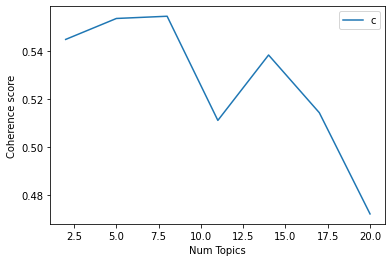

In [112]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=cleaned_list_tokenized, start=2, limit=21, step=3)
# Show graph
import matplotlib.pyplot as plt
start=2; limit=21; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

On voit que le nombre optimal de topics est de 8

In [114]:
%%time
from gensim.models import LdaModel

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=100,
    random_state=42,
    alpha='auto',
    eta='auto',
    num_topics=8,
    passes=10,
    per_word_topics=True
)

CPU times: user 3min 49s, sys: 1.23 s, total: 3min 51s
Wall time: 3min 49s


In [115]:
# Visualize the topics
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary=id2word, sort_topics = False)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.089229  0.374635       1        1  15.711610
1      0.144140 -0.010399       2        1   3.108886
2     -0.323858  0.036333       3        1  32.697195
3     -0.223337 -0.267647       4        1  20.993570
4      0.145380 -0.009822       5        1   4.340881
5      0.090496 -0.109542       6        1   8.979484
6      0.122642 -0.006567       7        1   7.841800
7      0.133767 -0.006991       8        1   6.326573, topic_info=          Term          Freq         Total Category  logprob  loglift
19       place  19557.000000  19557.000000  Default  30.0000  30.0000
24        food  31823.000000  31823.000000  Default  29.0000  29.0000
60        time  15564.000000  15564.000000  Default  28.0000  28.0000
29       order  13511.000000  13511.000000  Default  27.0000  27.0000
30     service  15650.000000  15650.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1372     truck    306.859767    307.754786   Topic8  -5.1050   2.7575
173       crap    302.564289    303.458903   Topic8  -5.1191   2.7575
1118     vegan    295.822503    296.716950   Topic8  -5.1417   2.7574
1115  mediocre    294.057992    294.952949   Topic8  -5.1476   2.7574
205        oil    631.873873    681.376473   Topic8  -4.3827   2.6850

[285 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1292      2  0.995792    addition
868       7  0.997738     apology
133       3  0.999786   appetizer
233       1  0.999712        area
339       7  0.999603  atmosphere
...     ...       ...         ...
182       6  0.999586        wing
440       4  0.999186        work
62        3  0.999788        year
1820      5  0.995447   yesterday
582       2  0.993433        yuck

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

### Ultime Remarque:  
Les warnings sont bel et bien là sur le notebook de Colab, mais Colab affiche quand même les topics.  
Apparemment ce n'est pas le cas sur Github.  
Que faire? j'ai tenté pyLDAvis.show() et pyLDAvis.display() comme décrit ici: [Doc pyLDAvis](https://pyldavis.readthedocs.io/en/latest/modules/API.html) mais sans succès